In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(color_codes=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


## Load the data

In [3]:
df = pd.read_csv('../cleaned_data/FREN.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,-0.077792,-0.039585,-0.041007,-0.484714,2.223844,2.575815,2.574613,1.633924,1.679844,1.552717,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,0.440118
2012-10-18,-0.003835,-0.007674,-0.010651,1.422315,0.937519,1.283190,1.404574,1.679668,1.748685,1.672304,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,0.201081
2012-10-19,0.038425,0.004293,0.002741,1.517442,1.158441,1.511092,1.626116,0.908951,0.920132,0.908441,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,0.293018
2012-10-22,0.093893,0.025567,0.019705,1.628038,1.070196,1.424646,1.546813,0.634583,0.627739,0.526947,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,0.274631
2012-10-23,0.141436,0.046841,0.028634,1.606590,0.794613,1.164224,1.310060,0.566140,0.561087,0.541269,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,0.219468


### Plot the Close price - our target

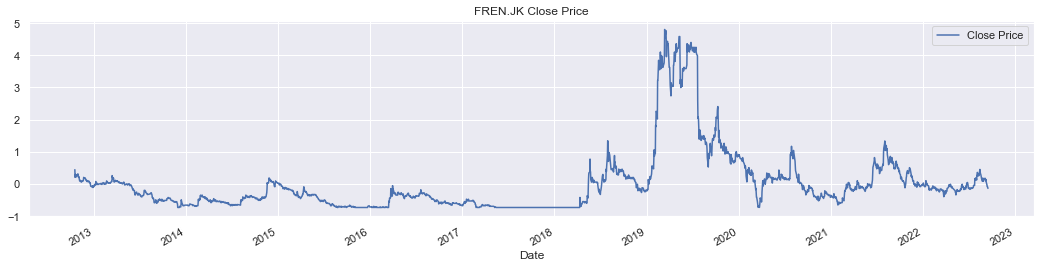

In [4]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('FREN.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [5]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Modeling

### Regression with Deep Neural Network

In [7]:
from utils import build_and_compile_model, fit_model

In [8]:
from utils import genPredictions, inversePredsAndAct, evaluateModel

In [9]:
from joblib import load

close_scaler = load('../feature_engineering/fren_close_scaler.bin')

In [10]:
epochs_cands = [100,150,200]
batch_size_cands = [32,64,128]
performances = {}
models = {}
predictions_dfs = {}
inversed_dfs = {}

modelID = 1
for epochs in epochs_cands:
    for batch_size in batch_size_cands:
        print(f'\n==========MODEL {modelID} with epochs: {epochs} and batch size: {batch_size}==========')
        model = build_and_compile_model(17)
        history = fit_model(model, epochs, batch_size, train_features, train_labels)
        models[f'Model-{modelID}'] = (model, history)
        predictions = genPredictions(model, df, test_features, train_len)
        predictions_dfs[f'Model-{modelID}'] = predictions
        
        inversed = inversePredsAndAct(predictions, close_scaler, test_labels)
        inversed_dfs[f'Model-{modelID}'] = inversed
        rmse_, mape_, rsquared_ = evaluateModel(inversed)
        performances[f'Model-{modelID}'] = {
            'Epochs': epochs,
            'Batch Size': batch_size,
            'RMSE': rmse_,
            'MAPE': mape_,
            'R2': rsquared_
        }
        
        modelID += 1
        


==========MODEL 1 with epochs: 100 and batch size: 32==========
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 2ms/step

==========MODEL 2 with epochs: 100 and batch size: 64==========
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape 

Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 2ms/step


In [11]:
performance_df = pd.DataFrame(performances).transpose()
performance_df[['Epochs', 'Batch Size']] = performance_df[['Epochs', 'Batch Size']].astype(int)
performance_df.head(9)

,Epochs,Batch Size,RMSE,MAPE,R2
Model-1,100,32,5.478009,4.364147,0.918193
Model-2,100,64,6.207009,5.049637,0.894971
Model-3,100,128,7.131693,5.787193,0.861347
Model-4,150,32,6.658311,5.490760,0.879143
Model-5,150,64,7.030671,5.231526,0.865247
Model-6,150,128,6.193749,5.552715,0.895419
Model-7,200,32,4.470471,3.412360,0.945518
Model-8,200,64,7.221722,5.057413,0.857824
Model-9,200,128,6.710832,5.617203,0.877229


### Plot the best model

In [12]:
from utils import plotPredAct, plotErrorHist

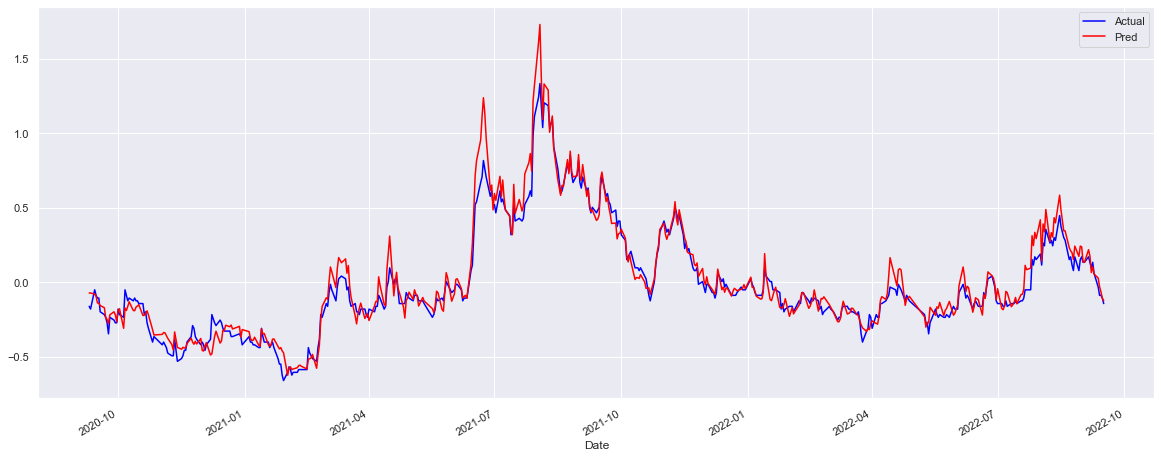

In [13]:
plotPredAct(predictions_dfs['Model-7'])

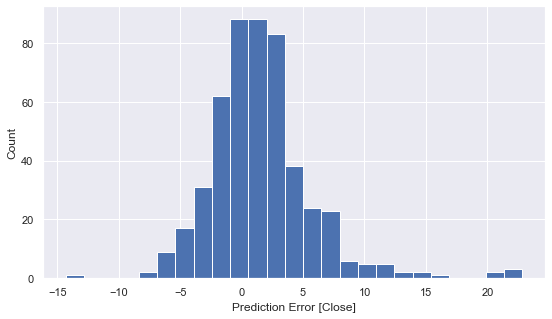

In [14]:
plt.figure(figsize=(9,5))
plotErrorHist(inversed_dfs['Model-7'])

### Save the best model

In [15]:
models['Model-7'][0].save('./models/fren.h5')

In [16]:
loadedModel = keras.models.load_model('./models/fren.h5')

In [17]:
loadedModel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                1152      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
